# **Import** **Libraries**

In [ ]:
import pandas as pd
import numpy as np
import ser
import lib_tree
import copy
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import  train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report, precision_score, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score1
import time
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline

# Loading Datasets

In [ ]:
Final_Data_S1= pd.read_csv("final_H358.csv")
Final_Data_S2= pd.read_csv("final_H355.csv")
Final_Data_S1.loc[Final_Data_S1[Final_Data_S1.labels.isin([ 3.0,4.0])].index, 'labels']=2.0
Final_Data_S2.loc[Final_Data_S2[Final_Data_S2.labels.isin([ 3.0,4.0])].index, 'labels']=2.0
ys = Final_Data_S1.labels
Xs= Final_Data_S1.drop(['Time', 'labels'], axis=1)
yt = Final_Data_S2.labels
Xt= Final_Data_S2.drop(['Time', 'labels'], axis=1)

In [ ]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.25, stratify = yt, random_state=42)
test_data = pd.concat([X_test_t, y_test_t], axis=1)
training_data = pd.concat([X_train_t, y_train_t], axis=1)

# Save the concatenated DataFrame to a CSV file
test_data.to_csv('test_data.csv', index=False)  # Set index=False to avoid saving the row indices
training_data.to_csv('train_data.csv', index=False)
print(X_test_t.shape)


(267, 7)


In [ ]:
train= pd.read_csv("train_data.csv")
test= pd.read_csv("test_data.csv")

class_counts = test['labels'].value_counts()

print("Number of instances per class:")
print(class_counts)

yt = train.labels
Xt= train.drop([ 'labels'], axis=1)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.9, stratify=yt,  random_state = 42)
X_train_t = X_train_t.to_numpy()
y_train_t= y_train_t.to_numpy()
y_test_t = test.labels
X_test_t = test.drop([ 'labels'], axis=1)

target_names = ['Class 0', 'Class 1', 'Class 2']

Number of instances per class:
labels
0    193
1     48
2     26
Name: count, dtype: int64


In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(Xs, ys)

# SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X_train_t, y_train_t)


In [ ]:
SER_smote = copy.deepcopy(clf)
ser.SER(0, SER_smote, X_resampled, y_resampled, original_ser=True)
y_pred = SER_smote.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)
print("accuracy:",accuracy_score(y_test_t, y_pred))
f1_weighted = f1_score( y_test_t, y_pred,average='weighted')
print('weighted f1 score:', f1_weighted)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix ser smote:")
print(cm)

accuracy: 0.8539325842696629
weighted f1 score: 0.8509468060029858
precision: [0.95336788 0.60714286 0.55555556]
recall; [0.95336788 0.70833333 0.38461538]
fscore: [0.95336788 0.65384615 0.45454545]
support: [193  48  26]
Confusion Matrix ser smote:
[[184   9   0]
 [  6  34   8]
 [  3  13  10]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


precision: [0.95336788 0.60714286 0.55555556]
recall; [0.95336788 0.70833333 0.38461538]
fscore: [0.95336788 0.65384615 0.45454545]
support: [193  48  26]
accuracy: 0.8426966292134831
Confusion Matrix ser smote:
[[178  15   0]
 [  9  37   2]
 [  1  15  10]]


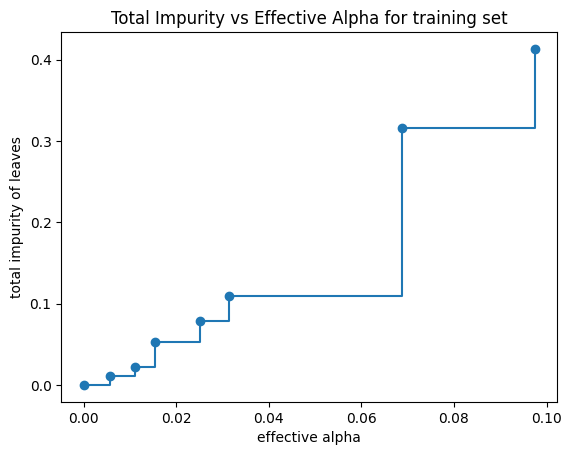

In [ ]:

# Path for cost complexity pruning
path = SER_smote.cost_complexity_pruning_path( X_resampled, y_resampled)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plot the pruning path
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs Effective Alpha for training set")

# Find the optimal value for ccp_alpha
optimal_ccp_alpha = ccp_alphas[np.argmin(impurities)]

# Create a new DecisionTreeClassifier with ccp_alpha parameter set
SER_smote = DecisionTreeClassifier(ccp_alpha=optimal_ccp_alpha, max_depth=3)

# Re-fit the tree
SER_smote.fit(X_resampled, y_resampled)

y_pred = SER_smote.predict(X_test_t)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
print("accuracy:",accuracy_score(y_test_t, y_pred))
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix ser smote:")
print(cm)

In [ ]:
f1_weighted = f1_score(y_pred, y_test_t, average='weighted')
print('weighted f1 score:', f1_weighted)

weighted f1 score: 0.8430444754557892


Micro-averaged One-vs-Rest ROC AUC score:
0.8820
Macro-averaged One-vs-Rest ROC AUC score:
0.7995


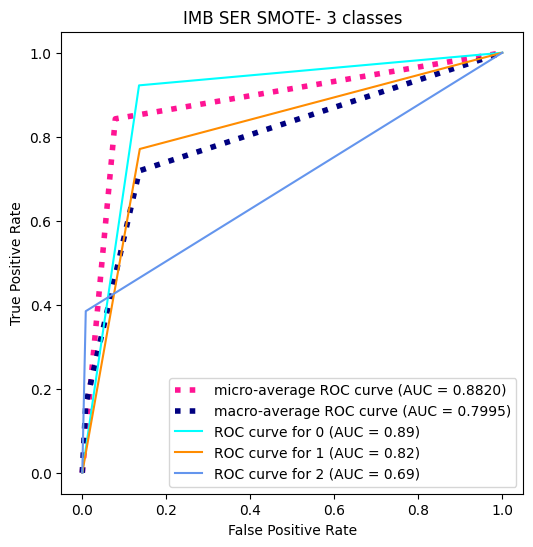

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
label_binarizer = LabelBinarizer().fit(y_test_t)
y_onehot_test = label_binarizer.transform(y_test_t)
y_onehot_test.shape  # (n_samples, n_classes)
label_binarizer.transform([0])

import matplotlib.pyplot as plt

y_pred_onehot = label_binarizer.transform(y_pred)



from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))


from sklearn.metrics import auc, roc_curve
n_classes = 3
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_pred_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.4f}")
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.4f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.4f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.4f}")
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(3), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred_onehot[:, class_id],
        name=f"ROC curve for {class_id}",
        color=color,
        ax=ax,
        #plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("IMB SER SMOTE- 3 classes")
plt.legend()
plt.show()

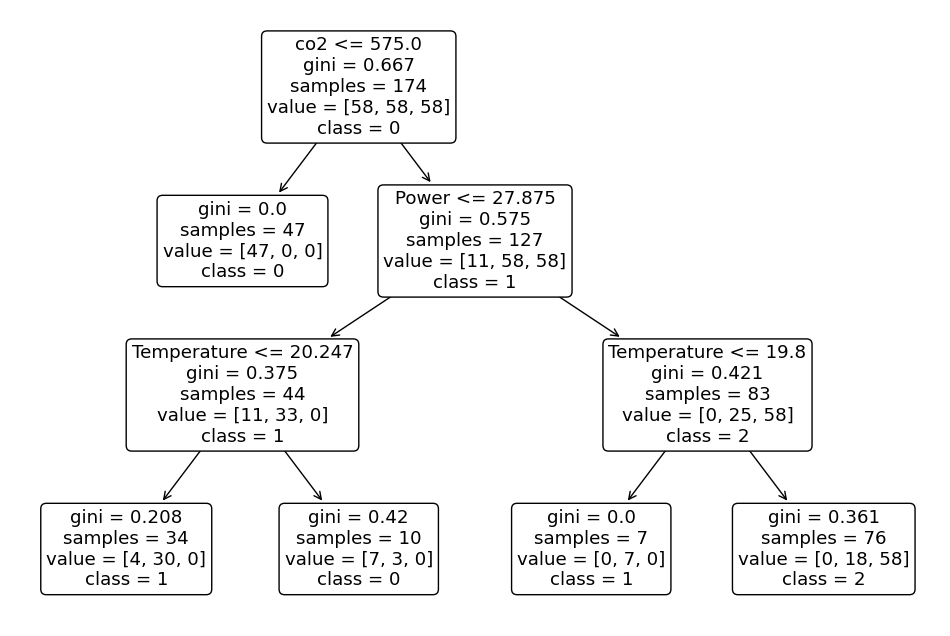

In [ ]:
plt.figure(figsize=(12, 8))
plot_tree(SER_smote, feature_names=['co2', 'Motion', 'RMS', 'Power', 'Temperature', 'Door_Contact', 'Window_Contact'], class_names=['0','1','2'], rounded=True)
plt.show()

## UNDERSAMPLING ClusterCentroids

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(
    estimator=MiniBatchKMeans(n_init=1), sampling_strategy='not majority'
)
X_res, y_res = cc.fit_resample(X_train_t, y_train_t)
SER_cluster = copy.deepcopy(clf)
ser.SERRR(0, SER_cluster, X_res, y_res, original_ser=True)
y_pred = SER_cluster.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
print("accuracy:",accuracy_score(y_test_t, y_pred))
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix ser smote:")
print(cm)

precision: [0.91044776 0.51020408 0.58823529]
recall; [0.94818653 0.52083333 0.38461538]
fscore: [0.92893401 0.51546392 0.46511628]
support: [193  48  26]
accuracy: 0.8164794007490637
Confusion Matrix ser smote:
[[183  10   0]
 [ 16  25   7]
 [  2  14  10]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


accuracy: 0.8576779026217228
precision: [0.935      0.60377358 0.71428571]
recall; [0.96891192 0.66666667 0.38461538]
fscore: [0.95165394 0.63366337 0.5       ]
support: [193  48  26]
Confusion Matrix imb ser ClusterCentroids:
[[187   6   0]
 [ 12  32   4]
 [  1  15  10]]


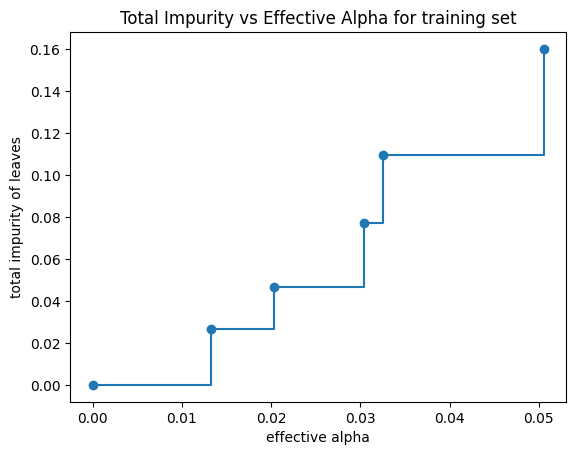

In [ ]:
# Path for cost complexity pruning
path = SER_cluster.cost_complexity_pruning_path(X_res, y_res)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plot the pruning path
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs Effective Alpha for training set")

# Find the optimal value for ccp_alpha
optimal_ccp_alpha = ccp_alphas[np.argmin(impurities)]

# Create a new DecisionTreeClassifier with ccp_alpha parameter set
SER_cluster = DecisionTreeClassifier(ccp_alpha=optimal_ccp_alpha, max_depth=3)

# Re-fit the tree
SER_cluster.fit(X_res, y_res)

y_pred = SER_cluster.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)

print("accuracy:",accuracy_score(y_test_t, y_pred))
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix imb ser ClusterCentroids:")
print(cm)

In [ ]:
#save best model
from joblib import dump, load
dump(SER_cluster, 'SER_cluster.joblib')
#SER_cluster= load('SER_cluster.joblib')

['SER_cluster.joblib']

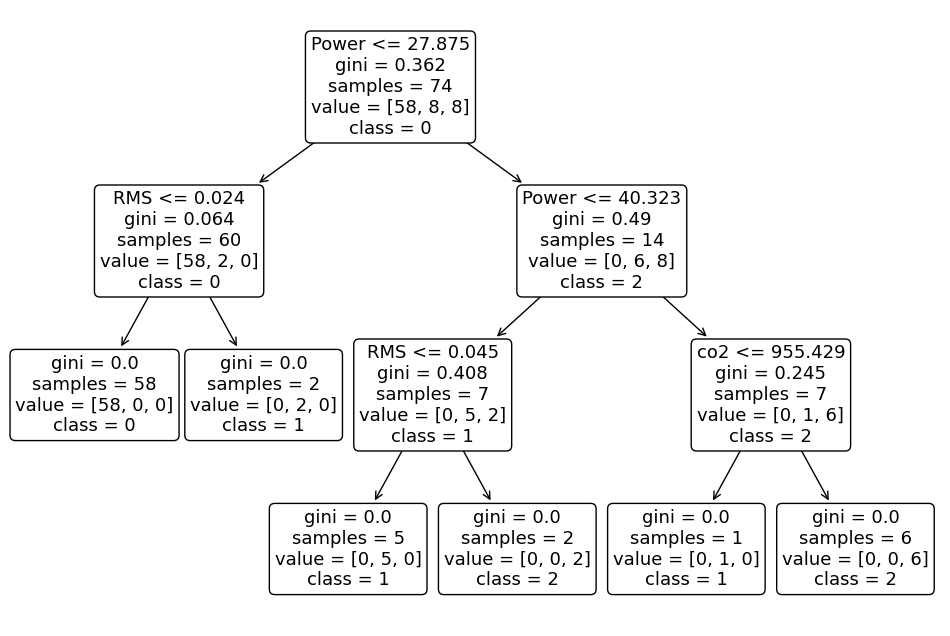

In [ ]:
plt.figure(figsize=(12, 8))
plot_tree(SER_cluster, feature_names=['co2', 'Motion', 'RMS', 'Power', 'Temperature', 'Door_Contact', 'Window_Contact'], class_names=['0','1','2'], rounded=True)
plt.show()

In [ ]:
import numpy as np
from sklearn.tree import _tree

def get_rules(dt, feature_names, class_names=None):
    tree_ = dt.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path, paths):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            # Store path and the outcome probability for each class at leaf
            path += [(tree_.value[node][0], tree_.n_node_samples[node])]
            paths.append(path)

    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    sorted_indices = np.argsort(samples_count)[::-1]  # sort descending
    paths = [paths[i] for i in sorted_indices]

    rules = []
    for path in paths:
        rule = "if "
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += p
        rule += " then "
        # handle both classification and regression trees
        if class_names:
            classes = path[-1][0]
            class_index = np.argmax(classes)
            rule += f"class: {class_names[class_index]} "
        else:
            rule += f"value: {np.round(path[-1][0][0], 3)}"

        rules.append(rule)

    return rules


In [ ]:
rules = get_rules(SER_cluster, ['co2', 'Motion', 'RMS', 'Power', 'Temperature', 'Door_Contact','Window_Contact'],['0','1', '2'])
for rule in rules:
    print(rule)

if (Power <= 27.875) and (RMS <= 0.024) then class: 0 
if (Power > 27.875) and (Power > 40.323) and (co2 > 955.429) then class: 2 
if (Power > 27.875) and (Power <= 40.323) and (RMS <= 0.045) then class: 1 
if (Power > 27.875) and (Power <= 40.323) and (RMS > 0.045) then class: 2 
if (Power <= 27.875) and (RMS > 0.024) then class: 1 
if (Power > 27.875) and (Power > 40.323) and (co2 <= 955.429) then class: 1 


In [ ]:
f1_weighted = f1_score(y_pred, y_test_t, average='weighted')
print('weighted f1 score:', f1_weighted)

weighted f1 score: 0.8648499895876886


Micro-averaged One-vs-Rest ROC AUC score:
0.8933
Macro-averaged One-vs-Rest ROC AUC score:
0.7887


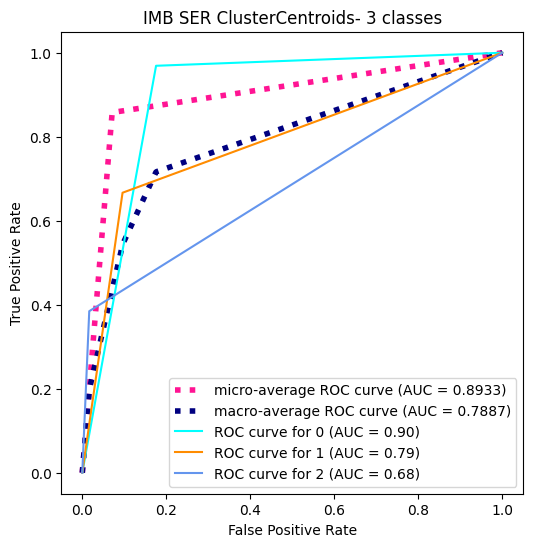

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
label_binarizer = LabelBinarizer().fit(y_test_t)
y_onehot_test = label_binarizer.transform(y_test_t)
y_onehot_test.shape  # (n_samples, n_classes)
label_binarizer.transform([0])

import matplotlib.pyplot as plt

y_pred_onehot = label_binarizer.transform(y_pred)



from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))


from sklearn.metrics import auc, roc_curve
n_classes = 3
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_pred_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.4f}")
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.4f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.4f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.4f}")
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(3), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred_onehot[:, class_id],
        name=f"ROC curve for {class_id}",
        color=color,
        ax=ax,
        #plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("IMB SER ClusterCentroids- 3 classes")
plt.legend()
plt.show()

## SMOTETOMEK

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTETomek
smt = SMOTETomek()
X_res, y_res = smt.fit_resample(X_train_t, y_train_t)

SER_tomek = copy.deepcopy(clf)
ser.SER(0, SER_tomek, X_res, y_res, original_ser=True)
y_pred = SER_tomek.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
print("accuracy:",accuracy_score(y_test_t, y_pred))
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix imb ser smotetomek:")
print(cm)


precision: [0.95263158 0.6031746  0.71428571]
recall; [0.93782383 0.79166667 0.38461538]
fscore: [0.94516971 0.68468468 0.5       ]
support: [193  48  26]
accuracy: 0.8576779026217228
Confusion Matrix imb ser smotetomek:
[[181  12   0]
 [  6  38   4]
 [  3  13  10]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


precision: [0.95721925 0.55882353 0.83333333]
recall; [0.92746114 0.79166667 0.38461538]
fscore: [0.94210526 0.65517241 0.52631579]
support: [193  48  26]
accuracy: 0.850187265917603
Confusion Matrix ser smotetomek:
[[179  14   0]
 [  8  38   2]
 [  0  16  10]]


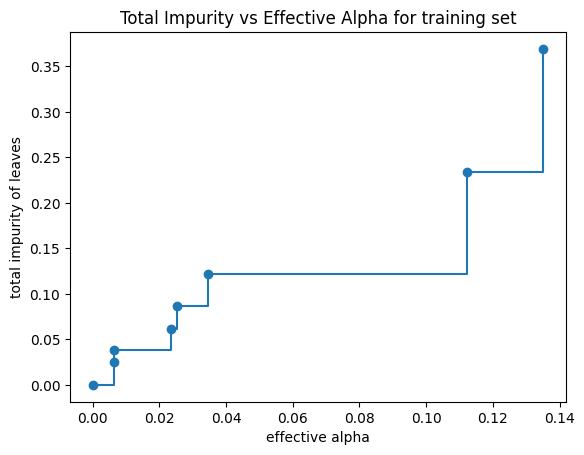

In [ ]:
# Assuming you have already defined dt_new and X_train_res, y_train_res

# Path for cost complexity pruning
path = SER_tomek.cost_complexity_pruning_path(X_res, y_res)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plot the pruning path
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs Effective Alpha for training set")

# Find the optimal value for ccp_alpha
optimal_ccp_alpha = ccp_alphas[np.argmin(impurities)]

# Create a new DecisionTreeClassifier with ccp_alpha parameter set
SER_tomekk = DecisionTreeClassifier(ccp_alpha=optimal_ccp_alpha, max_depth=3)

# Re-fit the tree
SER_tomekk.fit(X_res, y_res)

y_pred = SER_tomekk.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
print("accuracy:",accuracy_score(y_test_t, y_pred))
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix ser smotetomek:")
print(cm)

In [ ]:
f1_weighted = f1_score(y_pred, y_test_t, average='weighted')
print('weighted f1 score:', f1_weighted)

weighted f1 score: 0.8503415648769347


Micro-averaged One-vs-Rest ROC AUC score:
0.8876
Macro-averaged One-vs-Rest ROC AUC score:
0.8084


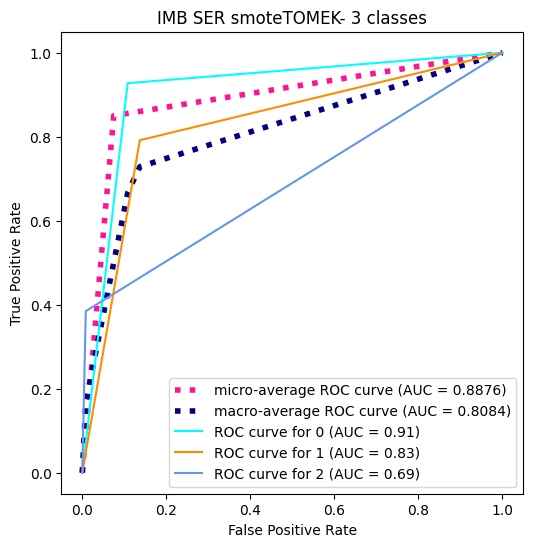

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
label_binarizer = LabelBinarizer().fit(y_test_t)
y_onehot_test = label_binarizer.transform(y_test_t)
y_onehot_test.shape  # (n_samples, n_classes)
label_binarizer.transform([0])

import matplotlib.pyplot as plt

y_pred_onehot = label_binarizer.transform(y_pred)



from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))


from sklearn.metrics import auc, roc_curve
n_classes = 3
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_pred_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.4f}")
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.4f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.4f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.4f}")
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(3), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred_onehot[:, class_id],
        name=f"ROC curve for {class_id}",
        color=color,
        ax=ax,
        #plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("IMB SER smoteTOMEK- 3 classes")
plt.legend()
plt.show()

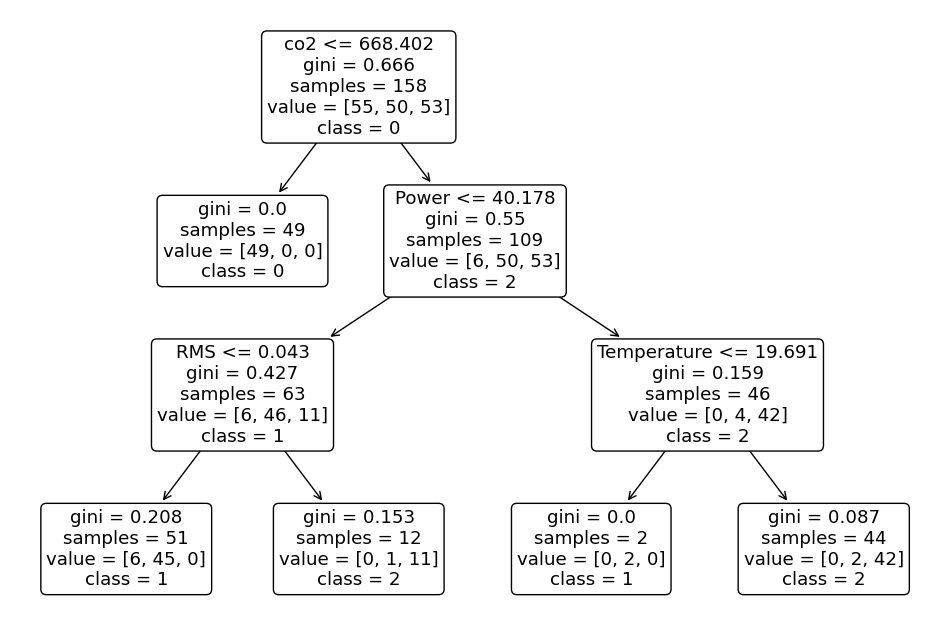

In [ ]:
plt.figure(figsize=(12, 8))
plot_tree(SER_tomekk, feature_names=['co2', 'Motion', 'RMS', 'Power', 'Temperature', 'Door_Contact', 'Window_Contact'], class_names=['0','1','2'], rounded=True)
plt.show()